# Distinct element estimation using k-th min 

Idealized $F_0$ estimation uses a random hash function to map elements from the stream to float values between 0 and 1. Ultimately, it maintains the smallest hash value $V$ and outputs ${1\over V}-1$ as the estimate $\tilde{F}_0$ for the number of distinct elements.

This algorithm uses the idea that the expected value of the smallest hash value is $1\over F_0+1$, where $F_0$ is the number of distinct elements. In fact, we can generally use the $k$-th smallest hash value $V_k$ for $k=1,2,\dots$.

In [1]:
# Import packages needed.
import random, math
import numpy as np
import matplotlib.pyplot as plt

To test the effect of k, we must first implement a function that takes a data sequence, hash each element to a value between 0 and 1, and returns the k-th smallest hash value. Python has a built-in hash function hash() that takes any hashable object and returns an integer hash. To convert a hash value to a float, we modular the hash with a large int and divide by it, for instance, $MAXINT=2^{63}-1$.

In [2]:
import sys
MAXINT = sys.maxsize

In [31]:
#update function that updates our k smallest values based on some hash
#its recursive
def update(store, lis, x):
    #if our store is the same length of lis we're done
    if(len(store)==len(lis)):
        return store
    #if this is the first pass
    elif(len(store)==0):
        #only add x to the front if its smaller than the front
        if(x<lis[0]):
            store.append(x)
            #change x to none so we know that a value has been added
            return update(store, lis, None)
        #if x is not smaller than copy the first element of lis
        else:
            store.append(lis[0])
            return update(store, lis, x)
    else:
        #we need to check if x has been added or not
        if(x != None):
            #we also need to check if x already exists in lis so we don't have a duplicate
            if(math.isclose(lis[len(store)],x)):
                #if x is a duplicate we don't need to do anything to lis since its already sorted
                return lis
            #if the next item in lis is bigger than x then we need to add x
            elif(lis[len(store)]>x):
                store.append(x)
                return update(store, lis, None)
            #if none of the above we just copy the current value
            else:
                store.append(lis[len(store)])
                return update(store, lis, x)
        #if x has already been chosen then we just need to add the next up element in lis
        #which is behind from store because we already added x
        else:
            store.append(lis[len(store)-1])
            return update(store, lis, x)
def kth_smallest_hash_value(input_list, k):
    #    maintain a list of the first k values sorted increasing
    #    1, 2, 3, 4, 5 if hash > x and hash < x+1: replace x + 1 with the value and shift up
    #a list to store the k smallest hash's at any time
    k_smallest = [2 for i in range(k)]
    #iterate over the elements of the stream
    for x in input_list:
        a=(hash(x) % MAXINT)/MAXINT
        k_smallest=update([], k_smallest, a)

    return k_smallest[k-1]
    

Now we will test k values between 1 to 10. For each k, we will generate a list of 1000 random **strings** using ``str(random.uniform(0,100))``, and estimate its cardinality via the returned value from the function ``kth_smallest_hash_value`` we implemented. For each k, we repeat this process 100 times and record the average and std of the estimates. Finally, we generate a plot with error bars to show the relation between estimates and k values. Note that the std for small k can be very large, so we need to set plt.ylim(-1000, 10000) to cap the y-axis for better visualization.

In [36]:
#storage for the 100 trials of each k
data= [[0 for i in range(100)] for j in range(10)]
#to store the mean of each k
mean=[0 for i in range(10)]
#to store the std of each k
std=[0 for i in range(10)]
#to store each "stream"
ran=[0 for i in range(1000)]
#to populate data
for i in range(10):
    for j in range(100):
        for a in range(1000):
            ran[a]=str(random.uniform(0,100))
        data[i][j]=((i+1)/kth_smallest_hash_value(ran,i+1))-1
#to calculate the mean and std for each k

for i in range(10):
    mean[i]=np.mean(data[i])
    std[i]=np.std(data[i])

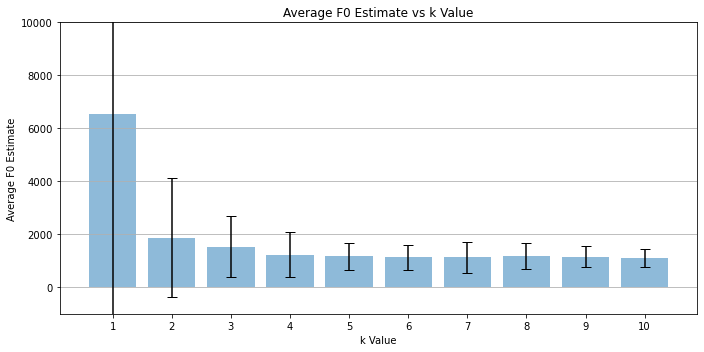

In [54]:
labels=['1','2','3','4','5','6','7','8','9','10']
x_pos=np.arange(10)
#mean of the data we're graphing
CTEs=mean
#error for the data we're graphing
error=std
fig, ax = plt.subplots(figsize=(10,5))


ax.bar(x_pos, CTEs,
       yerr=error,
       align='center',
       alpha=0.5,
       ecolor='black',
       capsize=5)
ax.set_ylabel('Average F0 Estimate')
ax.set_xlabel('k Value')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_title('Average F0 Estimate vs k Value')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
plt.ylim(-1000, 10000) 
plt.show()

## The median trick

In [64]:
def median_trick(generator, expectation, var, eps, delta):
    '''
    Input:
        generator - a function that generates one sample from a distribution when being called.
        expectation - Expectation of the distribution
        var - Variance of the distribution
        eps - epsilon (accuracy parameter) as defined in slide 13
        delta - delta (confidence parameter) as defined in slide 13
    Output:
        estimated value Q
    '''
    #the equation of k on the slides
    mean_number=math.ceil(var/(expectation*expectation*eps*eps))
    #the equation of t on the slides
    median_number=math.ceil(math.log(1/delta, math.e))
    #store the data
    data=[[0 for j in range(mean_number)] for i in range(median_number)]
    #populate data
    for i in range(median_number):
        for j in range(mean_number):
            data[i][j]=generator()
    #find the means
    mean=[0 for i in range(median_number)]
    for i in range(median_number):
        mean[i]=np.mean(data[i])
    #return the median of the t means of k values
    return np.median(mean)

Now we want to test the function with the following idea. Assume Q=2. The unbiased estimator, X of Q, generates estimates that follow a normal distribution with variance equal to 1. The generator for X is already given below as ``normal_generator``.

- First, we set eps=0.1, and test how the delta affects the estimates. Range delta in [1e-6, 1e-4, 1e-3, 0.01, 0.1]; we repeat the estimation 100 times for each delta value.

- Second, we set delta=0.1, and test how the epsilon affects the estimates. Range epsilon in [0.01, 0.02, 0.05, 0.1, 0.2]; repeat the estimation 100 times for each epsilon value.

In [59]:
def normal_generator():
    return np.random.normal(2,1)

In [73]:
#we'll test what changign delta does
#list of different deltas
delta=[1e-6, 1e-4, 1e-3, 0.01, 0.1]
#the data for every tested delta
data_d=[[0 for i in range(100)]for j in range(len(delta))]
#to populate the data
for x in range(len(data_d)):
    for y in range(100):
        data_d[x][y]=median_trick(normal_generator, 2, 1, .1, delta[x])
#store for the means and stds
mean_d=[0 for i in range(5)]
std_d=[0 for i in range(5)]
#finding the mean and std
for i in range(5):
    mean_d[i]=np.mean(data_d[i])
    std_d[i]=np.std(data_d[i])
#testing the effects of changing eps
eps=[0.01, 0.02, 0.05, 0.1, 0.2]
data_e=[[0 for i in range(100)]for j in range(len(eps))]
#populate the eps data
for x in range(len(data_e)):
    for y in range(100):
        data_e[x][y]=median_trick(normal_generator, 2, 1, eps[x], .1)
#finding the mean and std for the changing eps data
mean_e=[0 for i in range(5)]
std_e=[0 for i in range(5)]
for i in range(5):
    mean_e[i]=np.mean(data_e[i])
    std_e[i]=np.std(data_e[i])
#the labels for each graph
labels_d=['1e-6', '1e-4', '1e-3', '0.01', '0.1']
labels_e=['0.01', '0.02', '0.05', '0.1', '0.2']

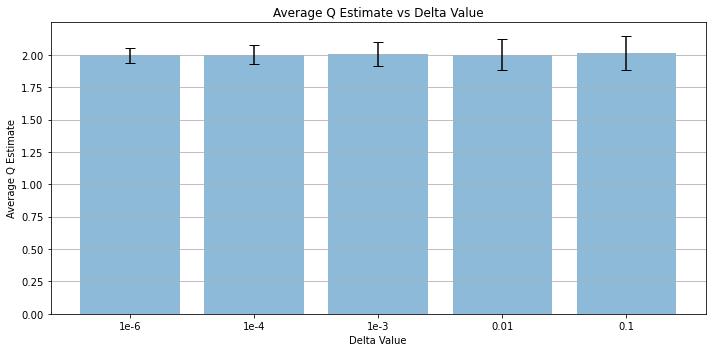

In [81]:
#mean of the data we're graphing
CTEs=mean_d
#error for the data we're graphing
error=std_d
fig, ax = plt.subplots(figsize=(10,5))
x_pos=np.arange(5)

ax.bar(x_pos, CTEs,
       yerr=error,
       align='center',
       alpha=0.5,
       ecolor='black',
       capsize=5)
ax.set_ylabel('Average Q Estimate')
ax.set_xlabel('Delta Value')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels_d)
ax.set_title('Average Q Estimate vs Delta Value')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()

plt.show()

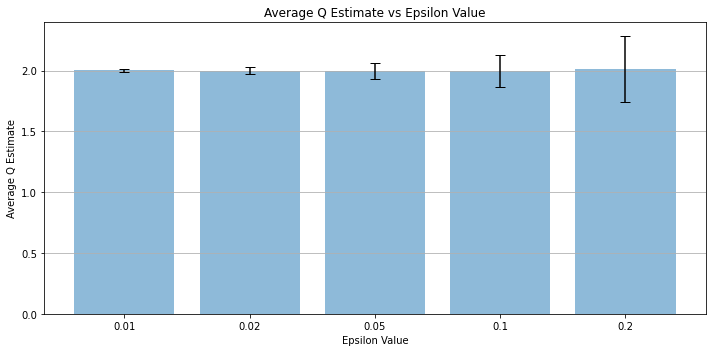

In [82]:
#mean of the data we're graphing
CTEs=mean_e
#error for the data we're graphing
error=std_e
fig, ax = plt.subplots(figsize=(10,5))
x_pos=np.arange(5)

ax.bar(x_pos, CTEs,
       yerr=error,
       align='center',
       alpha=0.5,
       ecolor='black',
       capsize=5)
ax.set_ylabel('Average Q Estimate')
ax.set_xlabel('Epsilon Value')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels_e)
ax.set_title('Average Q Estimate vs Epsilon Value')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()

plt.show()

## Morris Algorithm

Morris algorithm maintains a counter c that, for every element in the stream, itself increments by 1 with probability $1\over 2^c$. In the end, it outputs an estimate as $2^c-1$.

In this section, we will change the base of this counter. Instead of using 2 only, we use any base $1+\alpha$. We now increase the counter c with probability $1\over (1+\alpha)^c$. First, we implement the function ``morris_update_base_alpha`` below. **This function is called whenever we see an element from the stream to update the counter.**

In [85]:
def morris_update_base_alpha(counter, alpha):
    '''
    Input:
        counter - current value of counter c
        alpha - as defined in slide 51 alpha
    Output:
        updated value of counter c
    '''
    #setting the pr of heads to 1/(alpha+1)^c
    p=1/pow(1+alpha,counter)
    #generating a random number from [0,1]
    #if the number is from [0,p] then heads
    if(random.random() <= p):
        return counter + 1
    else:
        return counter


In [175]:
#a function to estimate x based on alph
def estimator(alpha):
    x=0
    #reads lines from the file
    with open("soc-hamsterster.edges", 'r') as file:
        for line in file:
            a=x
            #sets value of x to our estimated x for the current line
            x=morris_update_base_alpha(a, alpha)
    return x 
#to store each estimate
data=[[0 for i in range(100)]for j in range(8)]
#alphas
alpha=[2,3,4,5,6,7,8,9]
#to store the number of bits
bits=[[0 for i in range(100)]for j in range(8)]
#populate the data
for i in range(8):
    for j in range(100):
        x=estimator(alpha[i])
        #using the equation on page 51: estimate=((1+alpha)^x-1)/alpha=m
        data[i][j]=((pow((1+alpha[i]), x)-1)/alpha[i])
        #calculating number of bits
        bits[i][j]=math.ceil(math.log(x, 2))
#store the averages and stds
mean=[0 for i in range(8)]
std=[0 for i in range(8)]
mbits=[0 for i in range(8)]
sbits=[0 for i in range(8)]
for i in range(8):
    mean[i]=np.mean(data[i])
    std[i]=np.std(data[i])
    mbits[i]=np.mean(bits[i])
    sbits[i]=np.std(bits[i])
x_pos=np.arange(8)


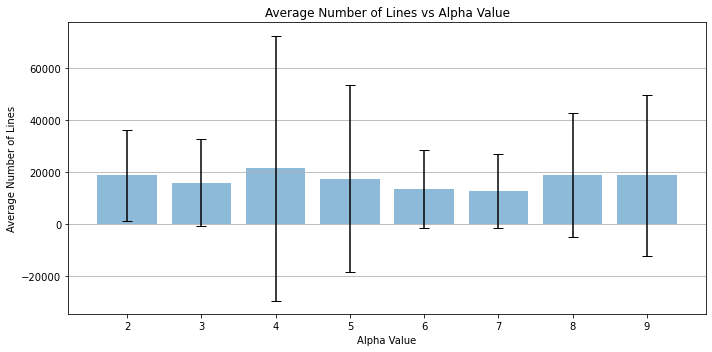

In [176]:
#mean of the data we're graphing
CTEs=mean
#error for the data we're graphing
error=std
fig, ax = plt.subplots(figsize=(10,5))

ax.bar(x_pos, CTEs,
       yerr=error,
       align='center',
       alpha=0.5,
       ecolor='black',
       capsize=5)
ax.set_ylabel('Average Number of Lines')
ax.set_xlabel('Alpha Value')
ax.set_xticks(x_pos)
ax.set_xticklabels(alpha)
ax.set_title('Average Number of Lines vs Alpha Value')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()

plt.show()

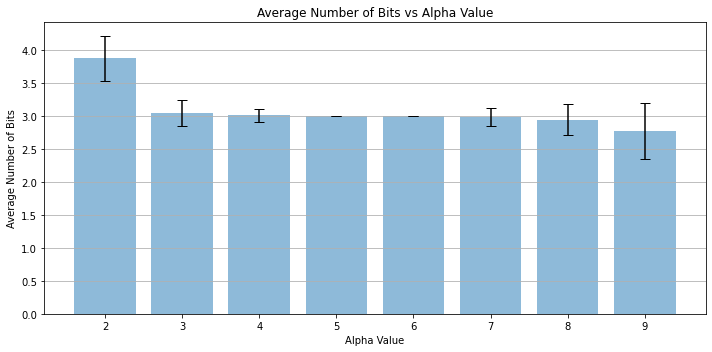

In [177]:
#mean of the data we're graphing
CTEs=mbits
#error for the data we're graphing
error=sbits
fig, ax = plt.subplots(figsize=(10,5))

ax.bar(x_pos, CTEs,
       yerr=error,
       align='center',
       alpha=0.5,
       ecolor='black',
       capsize=5)
ax.set_ylabel('Average Number of Bits')
ax.set_xlabel('Alpha Value')
ax.set_xticks(x_pos)
ax.set_xticklabels(alpha)
ax.set_title('Average Number of Bits vs Alpha Value')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()

plt.show()